# Проект по А/B-тестированию

## Введение

### Постановка задачи и цель исследования
Наша задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
- Оценим корректность проведения теста.
- Проанализируем результаты теста.
Чтобы оценить корректность проведения теста, проверим:
- пересечение тестовой аудитории с конкурирующим тестом;
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание
- Название теста: __recommender_system_test__;
- Группы: __А (контрольная), B (новая платёжная воронка)__;
- Дата запуска: __2020-12-07__;
- Дата остановки набора новых пользователей: __2020-12-21__;
- Дата остановки: __2021-01-04__;
- Аудитория: __15% новых пользователей из региона EU__;
- Назначение теста: __тестирование изменений, связанных с внедрением улучшенной рекомендательной системы__;
- Ожидаемое количество участников теста: __6000__;
- Ожидаемый эффект: __за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%__:
- конверсии в просмотр карточек товаров — __событие product_page__
- просмотры корзины — __product_cart__
- покупки — __purchase__.

### Описание данных

`/datasets/ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год;
__Структура файла:__
`name` — название маркетингового события;
`regions` — регионы, в которых будет проводиться рекламная кампания;
`start_dt` — дата начала кампании;
`finish_dt` — дата завершения кампании.

`/datasets/final_ab_new_users.csv` — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
__Структура файла:__
`user_id` — идентификатор пользователя;
`first_date` — дата регистрации;
`region` — регион пользователя;
`device` — устройство, с которого происходила регистрация.

`/datasets/final_ab_events.csv` — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
__Структура файла:__
`user_id` — идентификатор пользователя;
`event_dt` — дата и время события;
`event_name` — тип события;
`details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

`/datasets/final_ab_participants.csv` — таблица участников тестов.
__Структура файла:__
`user_id` — идентификатор пользователя;
`ab_test` — название теста;
`group` — группа пользователя.

### План проекта

- Опишем цели исследования.
- Исследуем данные:
    - Проверим, требуется ли преобразование типов.
    - Проверим, присутствуют ли пропущенные значения и дубликаты. Если да, то какова их природа.
    - Оценим корректность проведения теста. Дополнительно обратим внимание на:
        - Соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания.
        - Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.
        - Аудиторию теста. Убедимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.
- Проведем исследовательский анализ данных:
    - Проверим, количество событий на пользователя одинаково распределены в выборках?
    - Определим, как число событий в выборках распределено по дням?
    - Оценим, как меняется конверсия в воронке в выборках на разных этапах?
    - Проверим, какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
- Проведем оценку результатов A/B-тестирования:
    - Ответим на вопрос: "Что можно сказать про результаты A/B-тестирования?"
    - Проверим статистическую разницу долей z-критерием
Опишем выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделаем общее заключение о корректности проведения теста.

## Тело проекта

### Настроим необходимое в работе окружение

In [1]:
!pip install statsmodels==0.13.2
!pip install kaleido

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd # Импортируем библиотеку pandas для работы с таблицами
import datetime as dt
import numpy as np # для работы с массивами данных
from scipy import stats as st # для работы со статистикой
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt # Для работы с визуализацией данных 
import plotly.express as px
import plotly.io as pio
pio.renderers.default='png'
import seaborn as sns
import warnings # Отключим предупреждения платформы
warnings.simplefilter('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5 # Сразу установим увеличенный дефолтный размер графиков
from functools import reduce #для корректного объединения таблиц
pd.set_option('display.max_columns', 50) # настроим корректный вывод датасета

### Загрузим и изучим данные

In [3]:
 # выведем датасеты для первичного ознакомления а также познакомимся с его характеристиками
try:
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv') # для открытия в ЯП
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    ab_project_marketing_events = pd.read_csv('/work/ab_project_marketing_events.csv') # я работаю в DeepNote ^_^
    final_ab_new_users = pd.read_csv('/work/final_ab_new_users.csv')
    final_ab_events = pd.read_csv('/work/final_ab_events.csv')
    final_ab_participants = pd.read_csv('/work/final_ab_participants.csv')
   

print('таблица ab_project_marketing_events')
display(ab_project_marketing_events.info())
display(ab_project_marketing_events.head())
print('---'*10)
print('таблица final_ab_new_users')
display(final_ab_new_users.info())
display(final_ab_new_users.head())
print('---'*10)
print('таблица final_ab_events')
display(final_ab_events.info())
display(final_ab_events.head())
print('---'*10)
print('таблица final_ab_participants')
display(final_ab_participants.info())
final_ab_participants.head()

таблица ab_project_marketing_events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


------------------------------
таблица final_ab_new_users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


------------------------------
таблица final_ab_events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


------------------------------
таблица final_ab_participants
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Прежде чем приступать к изучению данных, произведем необходимые преобразования

таблица __`ab_project_marketing_events`__:
- столбец `start_dt` переведем в __datetime__ 
- `finish_dt` также переведем в __datetime__

таблица __`final_ab_new_users`__:
- столбец `first_date` переведем в __datetime__ 

таблица __`final_ab_events`__:
- столбец `event_dt` переведем в __datetime__ 

__Во всех таблицах:__
- Убедимся в отсутствии пропущенных значений
- Проверим наличие дубликатов
- Убедимся что период данных соответствует ТЗ


In [4]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'], format='%Y-%m-%d')
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'], format='%Y-%m-%d')
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'], format='%Y-%m-%d')
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format='%Y-%m-%d %H:%M:%S')
print(f'Тип данных столбца start_dt таблицы ab_project_marketing_events после изменения {ab_project_marketing_events["start_dt"].dtype}')
print(f'Тип данных столбца finish_dt таблицы ab_project_marketing_events после изменения {ab_project_marketing_events["finish_dt"].dtype}')
print(f'Тип данных столбца first_date таблицы final_ab_new_users после изменения {final_ab_new_users["first_date"].dtype}')
print(f'Тип данных столбца event_dt таблицы final_ab_events после изменения {final_ab_events["event_dt"].dtype}')
print('---'*10)
print(f'Доля пропусков в процентах в таблице ab_project_marketing_events:')
print(f'{(ab_project_marketing_events.isna().mean()*100).round(1)} %')
print(f'Доля пропусков в процентах в таблице final_ab_new_users:')
print(f'{(final_ab_new_users.isna().mean()*100).round(1)} %')
print(f'Доля пропусков в процентах в таблице final_ab_events:')
print(f'{(final_ab_events.isna().mean()*100).round(1)} %')
print(f'Доля пропусков в процентах в таблице final_ab_participants:')
print(f'{(final_ab_participants.isna().mean()*100).round(1)} %')
print('---'*10)
print(f'Доля полных дубликатов в процентах в таблице ab_project_marketing_events:')
print(f'{(ab_project_marketing_events.duplicated().mean()*100).round(1)} %')
print(f'Доля полных дубликатов в процентах в таблице final_ab_new_users:')
print(f'{(final_ab_new_users.duplicated().mean()*100).round(1)} %')
print(f'Доля полных дубликатов в процентах в таблице final_ab_events:')
print(f'{(final_ab_events.duplicated().mean()*100).round(1)} %')
print(f'Доля полных дубликатов в процентах в таблице final_ab_participants:')
print(f'{(final_ab_participants.duplicated().mean()*100).round(1)} %')

Тип данных столбца start_dt таблицы ab_project_marketing_events после изменения datetime64[ns]
Тип данных столбца finish_dt таблицы ab_project_marketing_events после изменения datetime64[ns]
Тип данных столбца first_date таблицы final_ab_new_users после изменения datetime64[ns]
Тип данных столбца event_dt таблицы final_ab_events после изменения datetime64[ns]
------------------------------
Доля пропусков в процентах в таблице ab_project_marketing_events:
name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64 %
Доля пропусков в процентах в таблице final_ab_new_users:
user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64 %
Доля пропусков в процентах в таблице final_ab_events:
user_id        0.0
event_dt       0.0
event_name     0.0
details       85.8
dtype: float64 %
Доля пропусков в процентах в таблице final_ab_participants:
user_id    0.0
group      0.0
ab_test    0.0
dtype: float64 %
------------------------------
Доля полны

Изменили необходимые типы данных и не обнаружили полных дубликатов в таблицах, однако обнаружили __85.8__ пропусков в столбце `details` таблицы final_ab_participants, сразу проверим их характер и примем решение о взаимодействии с ними:

Согласно струтуре данных: `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

In [5]:
final_ab_events.query('details.isnull()').head()

,user_id,event_dt,event_name,details
62740,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
62741,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
62742,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
62743,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
62744,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN


При более тщательной проверке данного столбца, понимаем, что наличие пропусков в нем, говорит лишь об отсутствии дополнительных сведений о событии, и никак не влияет на остальные данные. По ходу исследовательского анализа примем решение о необходимости замены значением заглушкой, на данном этапе вмешиваться в данные не будем. 

### Корректность проведения теста

В данном этапе Оценим корректность проведения теста. Дополнительно обратим внимание на:
- Соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания.
    - Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Убедимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования. Убедимся что остался только тест с названием: recommender_system_test, аудитория: 15% новых пользователей из региона EU;

#### Аудитория теста

Сразу убедимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования. Убедимся что остался только тест с названием: recommender_system_test, аудитория: 15% новых пользователей из региона EU;

In [6]:
print(f'Напомним что количество дубликатов в датасете равное: {final_ab_participants.duplicated().sum()}')
# Проверим пересечения тестов, выведем количество возможных тестов по датасету
print(f'Определимся с итоговым количеством тестов, оно равно: {final_ab_participants["ab_test"].nunique()}')
print(f'А именно: {final_ab_participants["ab_test"].unique()}')
# Соберем таблицу проверки причастности каждого пользователя к тестам
user_test = final_ab_participants.pivot_table(index='user_id', values='ab_test', aggfunc='count').reset_index()
user_test_cross = user_test.query('ab_test > 1')
print(f'Количество пользователей которые учавствуют сразу в двух тестах равное: {user_test_cross["user_id"].nunique()}')
print(f'Доля таких пользователей от общего количества участников тестов равна: {round(user_test_cross["user_id"].nunique() / user_test["user_id"].nunique() * 100, 2)} %')

Напомним что количество дубликатов в датасете равное: 0
Определимся с итоговым количеством тестов, оно равно: 2
А именно: ['recommender_system_test' 'interface_eu_test']
Количество пользователей которые учавствуют сразу в двух тестах равное: 1602
Доля таких пользователей от общего количества участников тестов равна: 9.61 %


Достаточно внушительная доля пользователей принимает участие сразу в двух тестах, и несмотря на возможную слабую активность  и т.д. по условиям ТЗ мы вынуждены удалить таких пользователей, далее сохраним таких пользователей и выполним фильтрацию по ним, также сразу выполним фильтрацию оставив только нужный тест, после чего сможем выполнить поиск пользователей находящихся в двух группах одновременно. 

In [7]:
user_test_cross_del =  pd.Series(user_test_cross["user_id"].unique())
user_test_cross_del = user_test_cross_del.to_list()
final_ab_data = final_ab_participants[~final_ab_participants.user_id.isin(user_test_cross_del)]
final_ab_data = final_ab_data.query('ab_test == "recommender_system_test"')
print(f'Промежуточно по результатам фильтрации потеряли данных: {round(len(final_ab_data) / len(final_ab_participants)*100,2)} %')

Промежуточно по результатам фильтрации потеряли данных: 27.91 %


In [8]:
# Соберем таблицу проверки причастности каждого пользователя к группам
user_group = final_ab_data.pivot_table(index='user_id', values='group', aggfunc='count').reset_index()
user_group_cross = user_group.query('group > 1')
print(f'Количество пользователей которые учавствуют сразу в двух группах равно: {user_group_cross["user_id"].nunique()}')
print(f'Доля таких пользователей от общего количества участников тестов равна: {round(user_group_cross["user_id"].nunique() / user_group["user_id"].nunique() * 100, 2)} %')

Количество пользователей которые учавствуют сразу в двух группах равно: 0
Доля таких пользователей от общего количества участников тестов равна: 0.0 %


Таким образом произведя необходимые фильтрации необходимо проверить главное условие ТЗ: __ожидаемое количество участников теста: 6000__

In [9]:
print(f'общее количество участников теста: {final_ab_data["user_id"].nunique()}')
print(f'При этом в группе А участников: {len(final_ab_data[final_ab_data.group == "A"])}')
print(f'A в  группе В участников: {len(final_ab_data[final_ab_data.group == "B"])}')
print(f'Таким образом различие в долях составит: {round(len(final_ab_data[final_ab_data.group == "A"])/len(final_ab_data)*100,2)} % в группе А, на {round(len(final_ab_data[final_ab_data.group == "B"])/len(final_ab_data)*100,2)} % в группе В от общего числа пользователей в тесте')
if final_ab_data["user_id"].nunique() >= 6000:
    print(f'Условия выполняется, отлично!')
else:
    print(f'Условие ТЗ по количетсву пользователей не выполнено')

общее количество участников теста: 5099
При этом в группе А участников: 2903
A в  группе В участников: 2196
Таким образом различие в долях составит: 56.93 % в группе А, на 43.07 % в группе В от общего числа пользователей в тесте
Условие ТЗ по количетсву пользователей не выполнено


Итак, мы понимаем что __условие ТЗ по количеству участников теста не выполнено__, отметим это и продвинемся дальше, нам необходимо проверить следующее условие аудитория: 15% новых пользователей из региона EU, то есть количество оставшихся после фильтрации пользователей должно быть равно  15% от всех новых пользователей из Евросоюза, которые были зарегистрированы с 07 по 21 число

In [10]:
ab_users_eu = final_ab_new_users.query('region == "EU"')
print(f'Общее количество пользователей из региона EU равно: {ab_users_eu["user_id"].nunique()}')
final_ab_users_eu = final_ab_data.merge(final_ab_new_users, on='user_id', how='left')
print(f'Количество пользователей в нашем тесте равно: {final_ab_users_eu["user_id"].nunique()}')

Общее количество пользователей из региона EU равно: 46270
Количество пользователей в нашем тесте равно: 5099


In [11]:
perc_15_eu_total = ab_users_eu['user_id'].nunique()*0.15
print(f'15 % Пользователей из региона EU составит: {perc_15_eu_total}')
if final_ab_users_eu['user_id'].nunique() >= perc_15_eu_total:
    print('Условие по ТЗ выполнено')
else:
    print('Условие по ТЗ не выполнено')

15 % Пользователей из региона EU составит: 6940.5
Условие по ТЗ не выполнено


#### Время проведения теста
Начнем с проверки столбцов имеющих данные о событиях и регитсрациях во всех столбцах.

In [12]:
print(f'таблица ab_project_marketing_events столбец start_dt')
print(f'Дата начала периодa {ab_project_marketing_events["start_dt"].min()}')
print(f'Дата конца периода {ab_project_marketing_events["start_dt"].max()}')
print(f'таблица ab_project_marketing_events столбец finish_dt')
print(f'Дата начала периодa {ab_project_marketing_events["finish_dt"].min()}')
print(f'Дата конца периода {ab_project_marketing_events["finish_dt"].max()}')
print(f'таблица final_ab_new_users столбец first_date')
print(f'Дата начала периодa {final_ab_new_users["first_date"].min()}')
print(f'Дата конца периода {final_ab_new_users["first_date"].max()}')
print(f'таблица final_ab_events столбец event_dt')
print(f'Дата начала периодa {final_ab_events["event_dt"].min()}')
print(f'Дата конца периода {final_ab_events["event_dt"].max()}')

таблица ab_project_marketing_events столбец start_dt
Дата начала периодa 2020-01-25 00:00:00
Дата конца периода 2020-12-30 00:00:00
таблица ab_project_marketing_events столбец finish_dt
Дата начала периодa 2020-02-07 00:00:00
Дата конца периода 2021-01-07 00:00:00
таблица final_ab_new_users столбец first_date
Дата начала периодa 2020-12-07 00:00:00
Дата конца периода 2020-12-23 00:00:00
таблица final_ab_events столбец event_dt
Дата начала периодa 2020-12-07 00:00:33
Дата конца периода 2020-12-30 23:36:33


Напомним, что по условиям ТЗ:
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;

Ни один столбец не вызывает требований к дополнительной проверке, __за исключением:__

В таблице final_ab_new_users столбец first_date, который содержит данные о дате регистрации пользователей, зарегистрировавшиеся с 7 по 21 декабря 2020 года, заметили:
`Дата конца периода 2020-12-23 00:00:00`
Что наталкивает нас на мысль что в данной таблице могут находиться пользователи которые мало того, что не попадают к нам в условия теста, еще и не вписываются в условия таблицы, определим таких пользователей ниже:

In [13]:
user_over_date = final_ab_new_users.query('first_date > "2020-12-21"')
print(f"Доля пользователей которые превышают лимит по дате: {round((user_over_date['user_id'].nunique() / final_ab_new_users['user_id'].nunique()) * 100,2)}%")                               

Доля пользователей которые превышают лимит по дате: 8.53%


In [14]:
user_del = pd.Series(user_over_date["user_id"].unique())
user_del = user_del.to_list()
final_ab_events = final_ab_events[~final_ab_events.user_id.isin(user_del)]
final_ab_new_users = final_ab_new_users[~final_ab_new_users.user_id.isin(user_del)]

Достаточно существенное вмешательство в данные, тем не менее, такие пользователи не подходят нам по ТЗ, поэтому выполнили фильтрацию.

По условию ТЗ - "ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%..."

Мы делаем вывод о том, что, нам необходимы только те пользователи, которые совершили действие в течении 14 дней  с момента регистрации.

Соответственно, нам необходимо оставить только тех пользователей, которые "подходят" нам по срокам регистрации, а также только те действия пользователей, которые совершались в течении 14 дней с момента регистрации, для этого мы:
- Выполним фильтрацию пользователей по дате регистрации
- Убедимся в необходимости или ее отсутсвтвии фильтрации пользователей из-за наличия других маркетинговых активностей проходящих в тот период
- Рассчитаем столбец `lifetime` который будет содержать информацию о промежутке, прошедшим между регистрацией и событием пользователя в днях
- Выполним фильтрацию событий которые произошли после периода 14 дней

In [15]:
print(f'По данным таблицы final_ab_events столбец event_dt')
print(f'Дата начала периодa {final_ab_events["event_dt"].min()}')
print(f'Дата конца периода {final_ab_events["event_dt"].max()}')
me_to_look = ab_project_marketing_events.query(
    '((start_dt >= "2020-12-07" or finish_dt >= "2020-12-07") or (start_dt >= "2020-12-07" and finish_dt >= "2020-12-07")) and regions.str.contains ("EU")'
)
                                               
display(me_to_look)
print(f'Так, мы получили {len(me_to_look)} новогодних события которые произошли в период нашего исследования, необходимо выяснить, повлияли ли они на активность наших пользователей в этот период.')

По данным таблицы final_ab_events столбец event_dt
Дата начала периодa 2020-12-07 00:00:33
Дата конца периода 2020-12-30 23:36:33


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Так, мы получили 1 новогодних события которые произошли в период нашего исследования, необходимо выяснить, повлияли ли они на активность наших пользователей в этот период.


Для определения степени вмешательства такие маркетинговых ивентов, проверим активность пользователей в период проведения таких ивентов

In [16]:
final_ab_events['event_day'] = final_ab_events['event_dt'].dt.date
final_ab_events.head(1)

,user_id,event_dt,event_name,details,event_day
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07


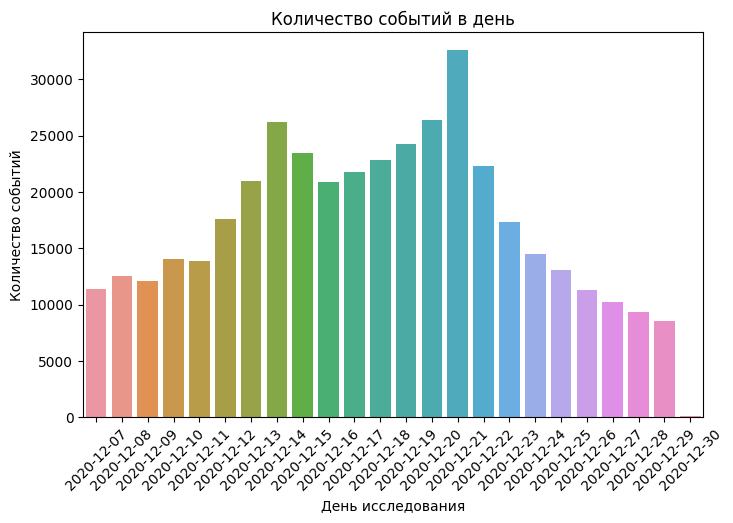

In [17]:
day_events = final_ab_events.pivot_table(index='event_day', values='event_dt', aggfunc='count').reset_index()
sns.barplot(data=day_events, x='event_day', y='event_dt').set(title='Количество событий в день', xlabel='День исследования', ylabel='Количество событий')
plt.xticks(rotation = 45)
plt.show()

Так, мы видим что количество пользователей начинает активно снижаться с 21 декабря, сразу после остановки набора новых пользователей, и продолжает равномерное снижение, таким образом __данные маркетинговые события никак не влияют на ход исследования, нормализация не требуется__

Теперь, рассчитаем столбец `lifetime` для каждого действия пользователя который будет содержать информацию о промежутке, прошедшим между регистрацией и событием пользователя в днях и отфильтруем те события, которые произошли после 14 дней с момента регистрации

In [18]:
user_events = final_ab_events.merge(final_ab_new_users, on='user_id', how='left')
user_events['lifetime'] = user_events['event_dt'] - user_events['first_date']
user_events_filter = user_events.query('lifetime <= "14 days"')
print(f'Доля данных, утерянных во время фильтрации: {abs(round((len(user_events_filter)/len(user_events)-1)*100, 2))} %')

Доля данных, утерянных во время фильтрации: 4.95 %


#### Промежуточный вывод:

Таким образом, при проверке корректности проведения теста, проверили: 
Убедились, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.Проверили равномерность распределения пользователей по тестовым группам и правильность их формирования. Убедились что остался только тест с названием: recommender_system_test, аудитория: 15% новых пользователей из региона EU;
- Соответствие данных требованиям технического задания. Проверили корректность всех пунктов технического задания.
- Время проведения теста. Убедились, что оно не совпадает с маркетинговыми и другими активностями.
- Аудиторию теста. 

После проведения всех фильтраций и проверок, выявились несоответствие условиям ТЗ, а именно:
Количество пользователей общее, меньше чем требуемое (6000) и количество пользователей меньше чем 15% от пользователей из EU

### Исследовательский анализ

- Проведем исследовательский анализ данных:
    - Проверим, количество событий на пользователя одинаково распределены в выборках?
    - Определим, как число событий в выборках распределено по дням?
    - Оценим, как меняется конверсия в воронке в выборках на разных этапах?
    - Проверим, какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

#### Количество событий на пользователя

In [19]:
list_final_ab_users = pd.Series(final_ab_users_eu['user_id'].unique())
list_final_ab_users = list_final_ab_users.to_list()
user_events_filter = user_events_filter.query('user_id == @list_final_ab_users')
user_events_filter.head()

,user_id,event_dt,event_name,details,event_day,first_date,region,device,lifetime
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,0 days 06:50:29
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,EU,PC,0 days 19:42:40
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,2020-12-07,EU,iPhone,0 days 06:31:24
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,2020-12-07,EU,PC,0 days 18:48:26
118,A9908F62C41613A8,2020-12-07 11:26:47,purchase,9.99,2020-12-07,2020-12-07,EU,PC,0 days 11:26:47


In [20]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [21]:
user_events_filter = user_events_filter.merge(final_ab_participants, on='user_id', how='left') # объединим для деления на группы
user_events_filter.head()

,user_id,event_dt,event_name,details,event_day,first_date,region,device,lifetime,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,0 days 06:50:29,A,recommender_system_test
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,EU,PC,0 days 19:42:40,A,recommender_system_test
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,2020-12-07,EU,iPhone,0 days 06:31:24,B,recommender_system_test
3,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,2020-12-07,EU,PC,0 days 18:48:26,B,recommender_system_test
4,A9908F62C41613A8,2020-12-07 11:26:47,purchase,9.99,2020-12-07,2020-12-07,EU,PC,0 days 11:26:47,B,recommender_system_test


In [22]:
user_events_a = user_events_filter[user_events_filter.group == "A"]
user_events_b = user_events_filter[user_events_filter.group == "B"]

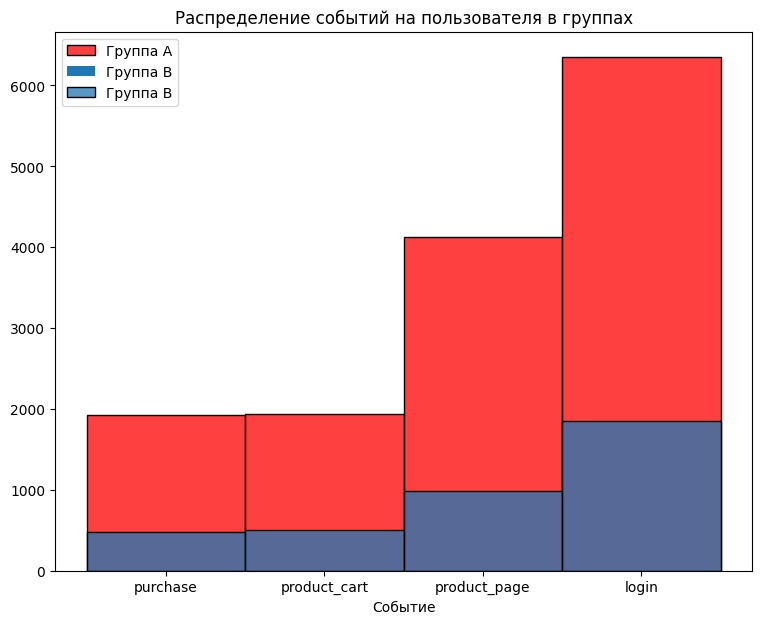

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax = sns.histplot(data=user_events_a, x='event_name', label='Группа А', color='red')
ax1 = sns.histplot(data=user_events_b, x='event_name', label='Группа B')
ax.legend()
ax.set_title('Распределение событий на пользователя в группах')
ax.set_xlabel('Событие')
ax.set_ylabel('')
plt.show()


In [24]:
user_events_a_mean = user_events_a.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()
user_events_b_mean = user_events_b.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()
print(f'Среднее количество событий на пользователя в группе А: {round(user_events_a_mean["event_name"].mean(),2)}')
print(f'Среднее количество событий на пользователя в группе B: {round(user_events_b_mean["event_name"].mean(),2)}')

Среднее количество событий на пользователя в группе А: 6.89
Среднее количество событий на пользователя в группе B: 5.4


Из трех событий:
- конверсии в просмотр карточек товаров — событие `product_page`,
- просмотры корзины — `product_cart`,
- покупки — `purchase`.

Мы имеем естественное неравномерное распределение в сторону просмотра карточки товаров, событие `product_page`. Что логично, ведь очень часто карточка открывается для принятия решения о помещении в корзину того или иного товара.

#### Количество событий в выборке по дням

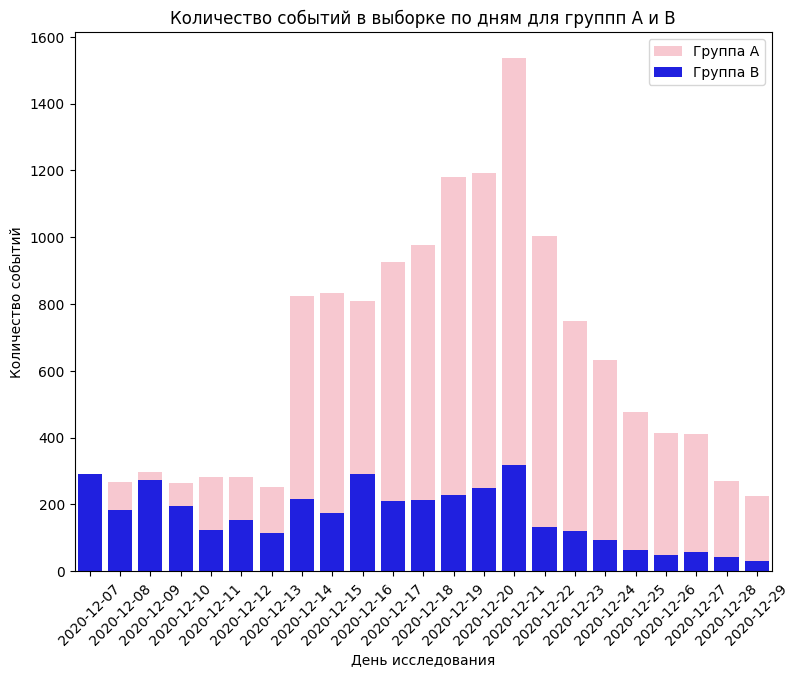

In [25]:
day_events_final_a = user_events_a.pivot_table(index='event_day', values='event_dt', aggfunc='count').reset_index()
day_events_final_b = user_events_b.pivot_table(index='event_day', values='event_dt', aggfunc='count').reset_index()
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax= sns.barplot(x='event_day', y='event_dt', color='pink', data=day_events_final_a, label='Группа А')
ax1 = sns.barplot(x='event_day', y='event_dt', color='blue', data=day_events_final_b, label='Группа В')
plt.xticks(rotation=45)
ax.legend()
ax.set_title('Количество событий в выборке по дням для группп А и В')
ax.set_xlabel('День исследования')
ax.set_ylabel('Количество событий')
plt.show()

По данному графику мы видим что количество событий распределены абсолютно нормально за исключением одного выброса на который необходимо обратить внимание 20-12-2020, природу которого достаточно легко объяснить:

In [26]:
dow = ("ISO Week days start from 1",

                "Понедельник",

                "Вторник",

                "Среда",

                "Четверг",

                "Пятница",

                "Суббота",

                "Воскресенье"

                )

abnormal_day     = dt.date(2020,12,20)

abnormal_day_dow = abnormal_day.isoweekday()

print("Интересующий нас день выпадает на {}".format(dow[abnormal_day_dow]))

Интересующий нас день выпадает на Воскресенье


Таким образом мы понимаем что данный всплеск активности это нормальное изменение активности пользователей в течении недели. 

#### Конверсия воронки на разных этапах

Проверим, как меняется конверсия в воронке в выборках на разных этапах

Самый простой способ построить воронку — посчитать, сколько раз наступило каждое событие. Сгруппируем датафрейм по полю event_name и посчитаем строки:

In [27]:
users_count = user_events_filter.groupby('event_name').agg({'user_id': 'nunique'}).reset_index()
users_count

,event_name,user_id
0,login,2787
1,product_cart,826
2,product_page,1757
3,purchase,850


Так, замечаем интересную особенность что покупок больше чем просмотров корзины, такое допустимо, ведь есть опция "быстрой покупки", также можем встретить ее под названием "купить в один клик" и т.д.
Теперь расположим позиции перед построением воронки в логическом порядке

In [28]:
df_mapping = pd.DataFrame({
    'event_name': ['login','product_page', 'product_cart', 'purchase'],
})
sort_mapping = df_mapping.reset_index().set_index('event_name')
sort_mapping

,index
event_name,
login,0
product_page,1
product_cart,2
purchase,3


In [29]:
users_count['event_num'] = users_count['event_name'].map(sort_mapping['index'])
users_count = users_count.sort_values('event_num')
users_count.head()

,event_name,user_id,event_num
0,login,2787,0
2,product_page,1757,1
1,product_cart,826,2
3,purchase,850,3


In [30]:
sample_a = user_events_filter[user_events_filter.group == "A"]
sample_b = user_events_filter[user_events_filter.group == "B"]
funnel_a = sample_a.groupby('event_name').agg({'user_id': 'nunique'}).reset_index()
funnel_a['event_num'] = funnel_a['event_name'].map(sort_mapping['index'])
funnel_a = funnel_a.sort_values('event_num')
funnel_b = sample_b.groupby('event_name').agg({'user_id': 'nunique'}).reset_index()
funnel_b['event_num'] = funnel_b['event_name'].map(sort_mapping['index'])
funnel_b = funnel_b.sort_values('event_num')
funnel_total =funnel_a.merge(funnel_b, on='event_name', how='left')
funnel_total = funnel_total.drop(['event_num_x', 'event_num_y'], axis=1)
funnel_total = funnel_total.rename(columns={'user_id_x': 'A', 'user_id_y': 'B'})
funnel_total

,event_name,A,B
0,login,2082,705
1,product_page,1360,397
2,product_cart,631,195
3,purchase,652,198


In [31]:
funnel_a = funnel_a.drop('event_num', axis=1)
funnel_b = funnel_b.drop('event_num', axis=1)
funnel_a['group'] = 'A'
funnel_b['group'] = 'B'
funnel_plot = pd.concat([funnel_a, funnel_b], axis=0)

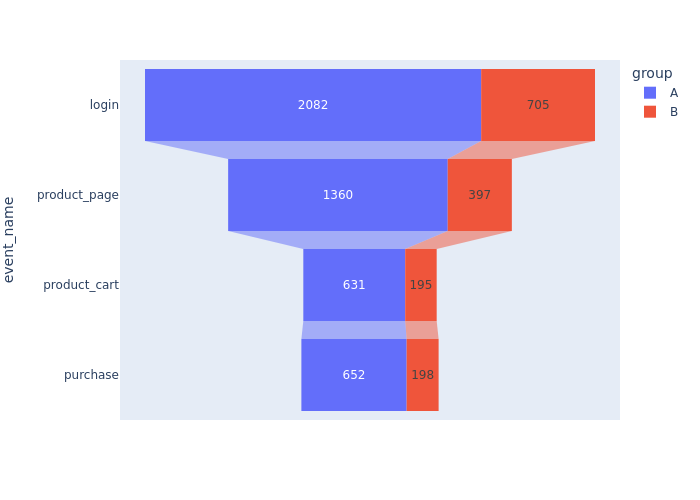

In [32]:
fig = px.funnel(funnel_plot, x='user_id', y='event_name', color='group')
fig.show()

Итак, просматривают продукты вдвое больше пользователей, чем переходят к корзине, совершают покупки чуть больше пользователей чем переходят в корзину, причину такого поведения объяснили выше.

#### Особенности данных которые нужно учесть

Необходимо учесть следующие особенности:
- Количество пользователей в тесте не соответстует ТЗ
- Количество пользователей в тесте не соответстует 15 % пользователей EU по ТЗ
- Количество совершивших покупку больше, чем посетивших страницу корзины.

In [33]:
print(f'Итого имеем следующие вводные:')
print(f'общее количество участников теста: {user_events_filter["user_id"].nunique()}')
print(f'При этом в группе А участников: {sample_a["user_id"].nunique()}')
print(f'A в  группе В участников: {sample_b["user_id"].nunique()}')
print(f'Таким образом различие в долях составит: {round(sample_a["user_id"].nunique()/user_events_filter["user_id"].nunique()*100,2)} % в группе А, на {round(sample_b["user_id"].nunique()/user_events_filter["user_id"].nunique()*100,2)} % в группе В от общего числа пользователей в тесте')

Итого имеем следующие вводные:
общее количество участников теста: 2788
При этом в группе А участников: 2082
A в  группе В участников: 706
Таким образом различие в долях составит: 74.68 % в группе А, на 25.32 % в группе В от общего числа пользователей в тесте


Тест выполнен с грубейшими нарушениями, вводные не соответвуют ТЗ, а группы при допустимом различии в 5% отличаются гораздо сильнее. 
Доли пользователей, перешедших из корзины в оплату по группам примено равны, что может свидетельствовать об ошибках в записи логов
Признать такого теста будет невозможно, а даже если и возможно, то интерпретация таких данных будет заведомо неверной и приведет к неверным решениям.

### Результаты A/B тестирования

Наша задача состояла в оценке результатов A/B-теста для новой рекомендательной системы. В результате проверки предоставленных данных были обнаружены множественные нарушения, в том числе и критичные, что не повзоляет производить дальнейшую оценку результатов эксперимента.

#### Статистический анализ

Проверим статистическую разницу долей z-критерием.
Для этого создадим два датасета с участниками по событиям по группам, после этого зададим пороговое значение alpha и чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим корректировку уровня значимости для уменьшения FWER методом Бонферрони с учетом что мы проводим сравнения по каждому из трех событий уровень статистической значимости снизим в 4 раз.

Считать будем по всем событиям, не исключая событие login, чтобы иметь "точку опоры"

Итоговая таблица с количеством пользователей по каждому событию будет выглядеть следующим образом:

In [34]:
users_id_count = user_events_filter.pivot_table(index='group', values='user_id', aggfunc='nunique').reset_index()
users_id_count

,group,user_id
0,A,2082
1,B,706


Сформулируем гипотезу исходя из нашего исследования которую необходимо проверить:

__Н0 - нулевая гипотеза__ - Между долями от числа всех пользователей в друх группах статистически значимой разницы нет
__Н1 - альтернативная гипотеза__ - Между долями статистически значимая разница есть

In [35]:
def z_test_check(df_1, df_2, alpha, x1, x2, ind_1, ind_2):
    for i in df_1.index:
        steps = np.array([df_1.loc[i, x1], df_1.loc[i, x2]])
        total_users = np.array([df_2.loc[ind_1, 'user_id'], df_2.loc[ind_2, 'user_id']])

        stat, p_value = proportions_ztest(steps, total_users)

        print(f'р-значение: {p_value} для сравнения групп {x1} и {x2} события, {df_1.loc[i, "event_name"]}')

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу, между долями есть статистически значимая разница')
            print('---'*10)
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между долями есть статитистически значимая разница')
            print('---'*10)

In [36]:
z_test_check(funnel_total, users_id_count, alpha=0.05/4, x1='A', x2='B', ind_1=0, ind_2=1)

р-значение: 0.0858740175477921 для сравнения групп A и B события, login
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между долями есть статитистически значимая разница
------------------------------
р-значение: 1.5371909704687067e-05 для сравнения групп A и B события, product_page
Отвергаем нулевую гипотезу, между долями есть статистически значимая разница
------------------------------
р-значение: 0.1766337419130104 для сравнения групп A и B события, product_cart
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между долями есть статитистически значимая разница
------------------------------
р-значение: 0.10281767567786751 для сравнения групп A и B события, purchase
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между долями есть статитистически значимая разница
------------------------------


Таким образом, по результату стат. исследования получили что статистически значимая разница есть только в событии product_page

## Выводы
В данном исследовании мы:

- Описали цели исследования.
- __Исследовали данные__:
    - Проверили, требуется ли преобразование типов.
    - Проверили, присутствуют ли пропущенные значения и дубликаты. Если да, то какова их природа.
    - __Сделали промежуточный вывод__: Изменили необходимые типы данных и не обнаружили полных дубликатов в таблицах, однако обнаружили 85.8 пропусков в столбце details таблицы final_ab_participants, сразу проверим их характер и примем решение о взаимодействии с ними: Согласно струтуре данных: details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах. При более тщательной проверке данного столбца, понимаем, что наличие пропусков в нем, говорит лишь об отсутствии дополнительных сведений о событии, и никак не влияет на остальные данные. По ходу исследовательского анализа примем решение о необходимости замены значением заглушкой, на данном этапе вмешиваться в данные не будем.

- Оценили __корректность проведения теста__. Дополнительно обратили внимание на:
    - Соответствие данных требованиям технического задания. Проверили корректность всех пунктов технического задания.
    - Время проведения теста. Убедились, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Убедились, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверили равномерность распределения пользователей по тестовым группам и правильность их формирования.
    - __Сделали промежуточный вывод__: После проведения всех фильтраций и проверок, выявились несоответствие условиям ТЗ, а именно:
Количество пользователей общее, меньше чем требуемое (6000) и количество пользователей меньше чем 15% от пользователей из EU

- __Провели исследовательский анализ данных__:
    - Проверили, количество событий на пользователя одинаково распределены ли в выборках
    - Определили, как число событий в выборках распределено по дням
    - Оценили, как меняется конверсия в воронке в выборках на разных этапах
    - Проверили, какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию
    - Сделали __промежуточный вывод__: Тест выполнен с грубейшими нарушениями, вводные не соответвуют ТЗ, а группы при допустимом различии в 5% отличаются гораздо сильнее. Доли пользователей, перешедших из корзины в оплату по группам примено равны, что может свидетельствовать об ошибках в записи логов
__Признать такого теста будет невозможно, а даже если и возможно, то интерпретация таких данных будет заведомо неверной и приведет к неверным решениям.__

- __Провели оценку результатов A/B-тестирования__:
    - Ответили на вопрос: "Что можно сказать про результаты A/B-тестирования?"
    - Проверили статистическую разницу долей z-критерием
    - __Сделали промежуточный вывод__: Наша задача состояла в оценке результатов A/B-теста для новой рекомендательной системы. В результате проверки предоставленных данных были обнаружены множественные нарушения, в том числе и критичные, что не повзоляет производить дальнейшую оценку результатов эксперимента. Также выяснили что статистически значимая разница есть только в событии product_page

Дадим общую рекомендацию, не считать тест завершенным и не принимать по нему никаких решений, а перезапустить его после нового года повторно, наладив отбор участников.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=106a8db8-5226-43bb-b26b-fb682cd0defc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>